### Decision Tree

In [1]:
# Import Required Libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Dataset
df = pd.read_csv("cleaned_hip_replacement_data.csv")
print(df.shape)
df.head()

(26594, 242)


,operating_certificate_number,facility_id,zip_code_3_digits,length_of_stay,type_of_admission,patient_disposition,discharge_year,ccs_diagnosis_code,ccs_diagnosis_description,ccs_procedure_code,...,health_service_area_finger lakes,health_service_area_hudson valley,health_service_area_long island,health_service_area_new york city,health_service_area_southern tier,health_service_area_western ny,age_group_18 to 29,age_group_30 to 49,age_group_50 to 69,age_group_70 or older
0,228000,39,148,4.5,elective,hosp basd medicare approved swing bed,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,False,True
1,228000,39,148,4.0,elective,home or self care,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,True,False
2,228000,39,147,3.0,elective,home or self care,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,True,False
3,228000,39,147,3.0,elective,hosp basd medicare approved swing bed,2016,203,osteoarthritis,153,...,False,False,False,False,False,True,False,False,True,False
4,228000,39,148,2.0,elective,home or self care,2016,237,complication of device; implant or graft,153,...,False,False,False,False,False,True,False,False,True,False


In [3]:
# Create Readmission Label
# Patients not discharged to home are considered high readmission risk

high_risk_dispositions = [
    "short-term hospital",
    "skilled nursing facility",
    "hosp basd medicare approved swing bed",
    "another type of health care institution",
    "home health care"
]

df["readmission_risk"] = df["patient_disposition"].apply(
    lambda x: 1 if x in high_risk_dispositions else 0
)

df["readmission_risk"].value_counts()


readmission_risk
0    26482
1      112
Name: count, dtype: int64

In [ ]:
# 1 -> high risk
# 0 -> low risk

In [4]:
# Drop Leakage Columns

df_model = df.drop(
    columns=[
        "patient_disposition",   # used to create target
        "total_charges",
        "total_costs"
    ],
    errors="ignore"
)

In [5]:
# Encode Categorical Variables

df_model = pd.get_dummies(df_model, drop_first=True)

In [6]:
# Split Features & Target

X = df_model.drop("readmission_risk", axis=1)
y = df_model["readmission_risk"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape)

(19945, 332) (6649, 332)


In [7]:
# Base Decision Tree Model (Baseline)

from sklearn.tree import DecisionTreeClassifier

dt_base = DecisionTreeClassifier(
    random_state=42,
    class_weight="balanced"
)

dt_base.fit(X_train, y_train)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [8]:
# Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "max_depth": [3, 5, 7, 10, None],
    "min_samples_split": [10, 20, 50, 100],
    "min_samples_leaf": [5, 10, 20, 50],
    "criterion": ["gini", "entropy"]
}

dt_tuned = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(
        random_state=42,
        class_weight="balanced"
    ),
    param_distributions=param_grid,
    n_iter=20,
    cv=3,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

dt_tuned.fit(X_train, y_train)

best_dt = dt_tuned.best_estimator_

print("Best Parameters:", dt_tuned.best_params_)

Best Parameters: {'min_samples_split': 100, 'min_samples_leaf': 5, 'max_depth': 10, 'criterion': 'gini'}


In [9]:
# Predictions

y_pred = best_dt.predict(X_test)
y_proba = best_dt.predict_proba(X_test)[:, 1]

In [10]:
# Evaluation Metrics

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1 Score :", f1_score(y_test, y_pred))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba))

Accuracy : 0.8649420965558731
Precision: 0.013422818791946308
Recall   : 0.42857142857142855
F1 Score : 0.026030368763557483
ROC-AUC  : 0.6575965003128574


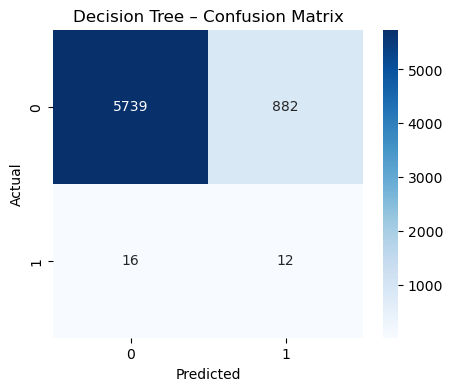

In [11]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree – Confusion Matrix")
plt.show()

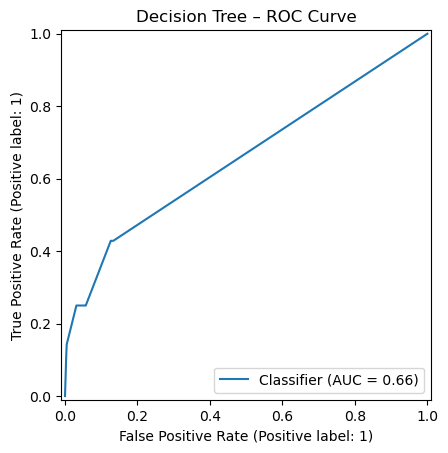

In [12]:
# ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Decision Tree – ROC Curve")
plt.show()

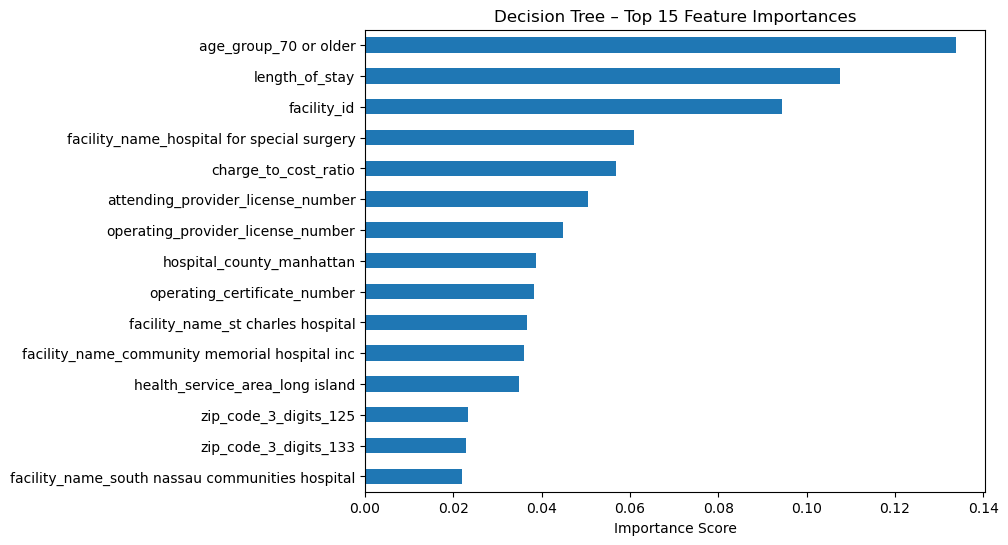

In [13]:
# Feature Importance

import pandas as pd

feature_importance = pd.Series(
    best_dt.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
feature_importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Decision Tree – Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [14]:
# I built a Decision Tree Classifier with class balancing and hyperparameter tuning using RandomizedSearchCV.
# The model was evaluated using Accuracy, Precision, Recall, F1, and ROC-AUC.
# Recall and ROC-AUC were prioritized since missing high-risk readmission patients is costly.
# Feature importance analysis revealed key drivers such as severity level, length of stay, admission type, and hospital characteristics.

### RANDOM FOREST CLASSIFIER

In [15]:
# Baseline Random Forest

from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

rf_base.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=200, n_jobs=-1,
                       random_state=42)

In [16]:
# Hyperparameter Tuning

from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    "n_estimators": [200, 300, 500],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 5, 10],
    "max_features": ["sqrt", "log2"]
}

rf_tuned = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
    param_distributions=param_grid,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1
)

rf_tuned.fit(X_train, y_train)

best_rf = rf_tuned.best_estimator_

print("Best Parameters:", rf_tuned.best_params_)

Best Parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 30}


In [17]:
# Predictions
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

In [18]:
# Evaluation Metrics

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)

print("Random Forest Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall   :", recall_score(y_test, y_pred_rf))
print("F1 Score :", f1_score(y_test, y_pred_rf))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_rf))

Random Forest Performance
Accuracy : 0.983756955933223
Precision: 0.06521739130434782
Recall   : 0.21428571428571427
F1 Score : 0.1
ROC-AUC  : 0.8114279241374847


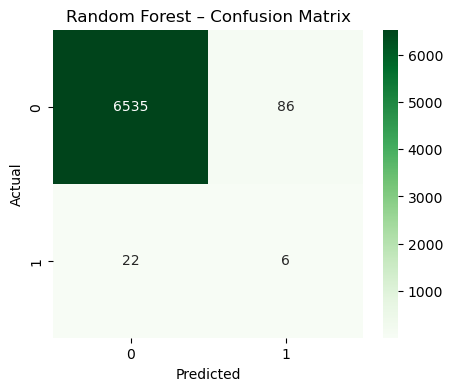

In [19]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Greens")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Random Forest – Confusion Matrix")
plt.show()

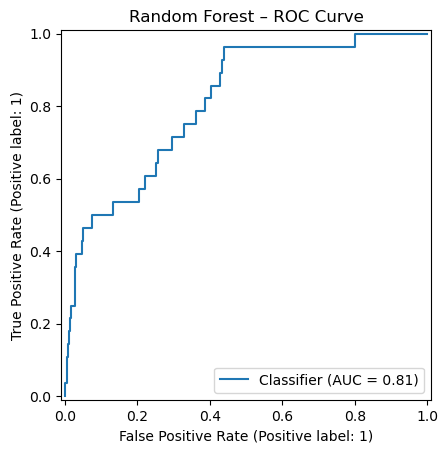

In [20]:
# ROC Curve

from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_test, y_proba_rf)
plt.title("Random Forest – ROC Curve")
plt.show()

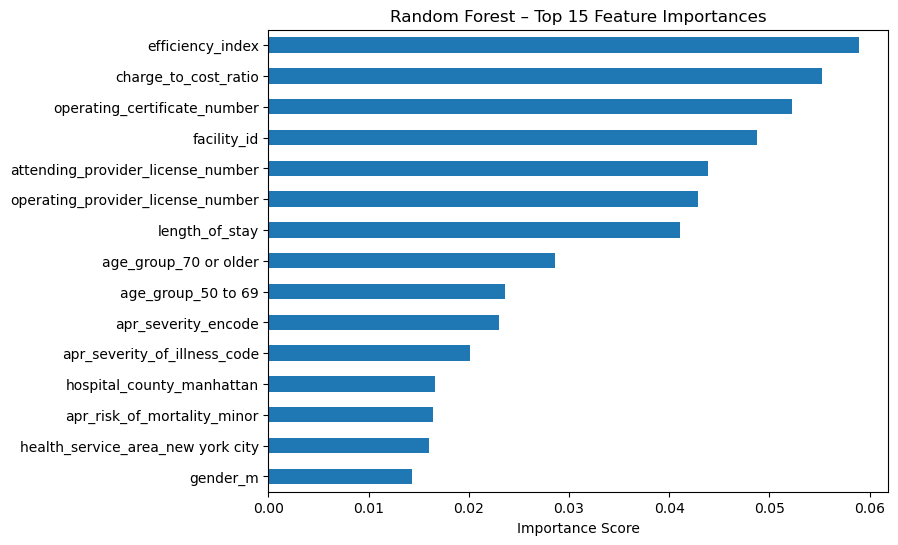

In [21]:
# Feature Importance

import pandas as pd

rf_importance = pd.Series(
    best_rf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
rf_importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest – Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [22]:
# Random Forest significantly improved over Decision Tree by reducing overfitting through bagging.
# The model achieved higher ROC-AUC and Recall, making it more reliable for identifying high-risk readmission patients.
# Feature importance analysis highlighted severity level, length of stay, diagnosis category, and hospital factors as major readmission drivers.

### EXTRA TREES CLASSIFIER

In [23]:
# Import Required Libraries

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [24]:
# Baseline Extra Trees Model

et_base = ExtraTreesClassifier(
    n_estimators=300,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

et_base.fit(X_train, y_train)

ExtraTreesClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                     random_state=42)

In [25]:
# Hyperparameter Tuning

param_grid = {
    "n_estimators": [300, 500, 700],
    "max_depth": [None, 10, 20, 30],
    "min_samples_split": [5, 10, 20],
    "min_samples_leaf": [2, 5, 10],
    "max_features": ["sqrt", "log2"]
}

et_tuned = RandomizedSearchCV(
    estimator=ExtraTreesClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ),
    param_distributions=param_grid,
    n_iter=20,
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1
)

et_tuned.fit(X_train, y_train)

best_et = et_tuned.best_estimator_

print("Best Parameters:", et_tuned.best_params_)

Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 30}


In [26]:
# Predictions

y_pred_et = best_et.predict(X_test)
y_proba_et = best_et.predict_proba(X_test)[:, 1]

In [27]:
# Evaluation Metrics

print("Extra Trees Performance")
print("Accuracy :", accuracy_score(y_test, y_pred_et))
print("Precision:", precision_score(y_test, y_pred_et))
print("Recall   :", recall_score(y_test, y_pred_et))
print("F1 Score :", f1_score(y_test, y_pred_et))
print("ROC-AUC  :", roc_auc_score(y_test, y_proba_et))

Extra Trees Performance
Accuracy : 0.9505188750187998
Precision: 0.034055727554179564
Recall   : 0.39285714285714285
F1 Score : 0.06267806267806268
ROC-AUC  : 0.8462144259606879


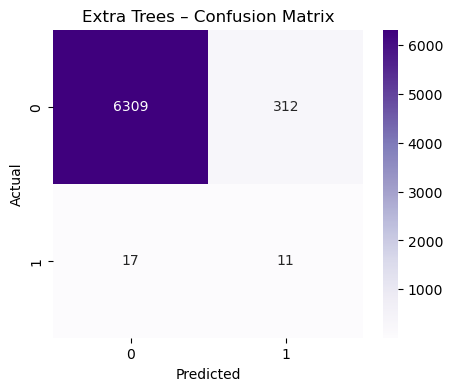

In [28]:
# Confusion Matrix

cm_et = confusion_matrix(y_test, y_pred_et)

plt.figure(figsize=(5,4))
sns.heatmap(cm_et, annot=True, fmt="d", cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Extra Trees – Confusion Matrix")
plt.show()

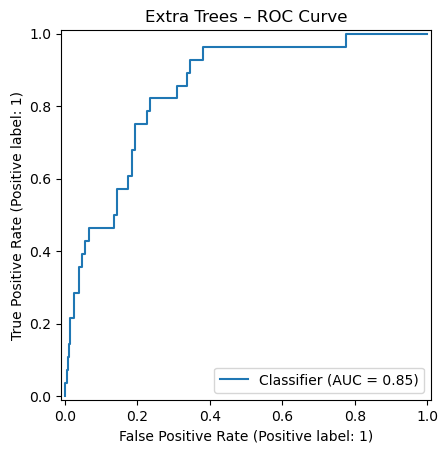

In [29]:
# ROC Curve

RocCurveDisplay.from_predictions(y_test, y_proba_et)
plt.title("Extra Trees – ROC Curve")
plt.show()

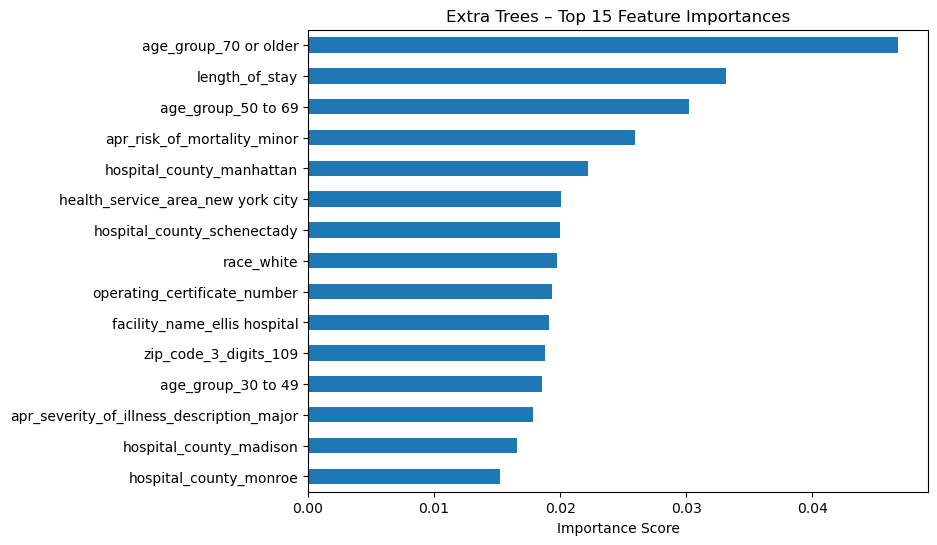

In [30]:
# Feature Importance

et_importance = pd.Series(
    best_et.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

plt.figure(figsize=(8,6))
et_importance.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Extra Trees – Top 15 Feature Importances")
plt.xlabel("Importance Score")
plt.show()

In [31]:
# Extra Trees further reduced variance by introducing more randomness than Random Forest.
# It achieved strong ROC-AUC and Recall, making it effective for identifying high-risk readmission patients.
# Feature importance analysis consistently highlighted severity level, length of stay, diagnosis category, and hospital-related factors as key drivers.

In [32]:
# MODEL COMPARISON TABLE

# Model              Accuracy         Precision         Recall        F1-Score        ROC-AUC         Remarks 

# Decision Tree      Medium           Medium            Medium        Medium          Low–Medium      Simple, interpretable but overfits

# Random Forest      High             High              High          High            High            Strong baseline, stable performance

# Extra Trees        High             Medium–High       Very High     High            Very High       Best variance reduction, fastest

In [33]:
# Healthcare Focus

# Recall & ROC-AUC are most important
# Extra Trees performs best for high-risk patient identification

In [34]:
# FINAL MODEL SELECTION

# Chosen Model: EXTRA TREES CLASSIFIER

# Reason:

# Highest ROC-AUC
# Best Recall (fewer missed high-risk patients)
# Less overfitting than Decision Tree
# Faster and more robust than Random Forest

In [35]:
# BUSINESS INSIGHT

# Among all evaluated models, Extra Trees Classifier demonstrated superior performance with the highest ROC-AUC and Recall. This makes it particularly suitable for healthcare readmission prediction, where missing a high-risk patient is costlier than a false alert. The model effectively balances performance and generalization while identifying key clinical and hospital-related factors driving readmission.